In [1]:
from pycocotools.coco import COCO

dataDir = "dataset/train2014"
dataType = "train2014"
annFile = "dataset/annotations/instances_train2014.json"
imageDir = "dataset/train2014/"

# Initialize the COCO api for instance annotations
coco = COCO(annFile)


loading annotations into memory...
Done (t=4.05s)
creating index...
index created!


In [2]:
categories = coco.loadCats(coco.getCatIds())
for cat in categories:
    print(f"ID: {cat['id']}, Name: {cat['name']}")

ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15, Name: bench
ID: 16, Name: bird
ID: 17, Name: cat
ID: 18, Name: dog
ID: 19, Name: horse
ID: 20, Name: sheep
ID: 21, Name: cow
ID: 22, Name: elephant
ID: 23, Name: bear
ID: 24, Name: zebra
ID: 25, Name: giraffe
ID: 27, Name: backpack
ID: 28, Name: umbrella
ID: 31, Name: handbag
ID: 32, Name: tie
ID: 33, Name: suitcase
ID: 34, Name: frisbee
ID: 35, Name: skis
ID: 36, Name: snowboard
ID: 37, Name: sports ball
ID: 38, Name: kite
ID: 39, Name: baseball bat
ID: 40, Name: baseball glove
ID: 41, Name: skateboard
ID: 42, Name: surfboard
ID: 43, Name: tennis racket
ID: 44, Name: bottle
ID: 46, Name: wine glass
ID: 47, Name: cup
ID: 48, Name: fork
ID: 49, Name: knife
ID: 50, Name: spoon
ID: 51, Name: bowl
ID: 5

In [ ]:
from dataset import COCODatasetLOADER

dataset = COCODatasetLOADER(coco, imageDir, size=(512, 512))



tensor([[[0.4314, 0.4157, 0.4157,  ..., 0.4510, 0.4471, 0.4510],
         [0.4275, 0.4235, 0.4275,  ..., 0.4431, 0.4392, 0.4353],
         [0.4235, 0.4275, 0.4392,  ..., 0.4549, 0.4510, 0.4471],
         ...,
         [0.4902, 0.5373, 0.5412,  ..., 0.9647, 0.9765, 0.9765],
         [0.4902, 0.5216, 0.5490,  ..., 0.9569, 0.9765, 0.9765],
         [0.4941, 0.5216, 0.5686,  ..., 0.9020, 0.9686, 0.9725]],

        [[0.5882, 0.5843, 0.5882,  ..., 0.6000, 0.6039, 0.6118],
         [0.5882, 0.5882, 0.5922,  ..., 0.6000, 0.6000, 0.6039],
         [0.5922, 0.5843, 0.5922,  ..., 0.6078, 0.6078, 0.6078],
         ...,
         [0.1843, 0.2471, 0.2471,  ..., 0.9765, 0.9922, 0.9922],
         [0.1882, 0.2392, 0.2588,  ..., 0.9686, 0.9922, 0.9922],
         [0.1961, 0.2314, 0.2863,  ..., 0.9176, 0.9843, 0.9882]],

        [[0.7569, 0.7451, 0.7412,  ..., 0.7451, 0.7412, 0.7373],
         [0.7608, 0.7529, 0.7529,  ..., 0.7412, 0.7373, 0.7333],
         [0.7608, 0.7569, 0.7608,  ..., 0.7373, 0.7333, 0.

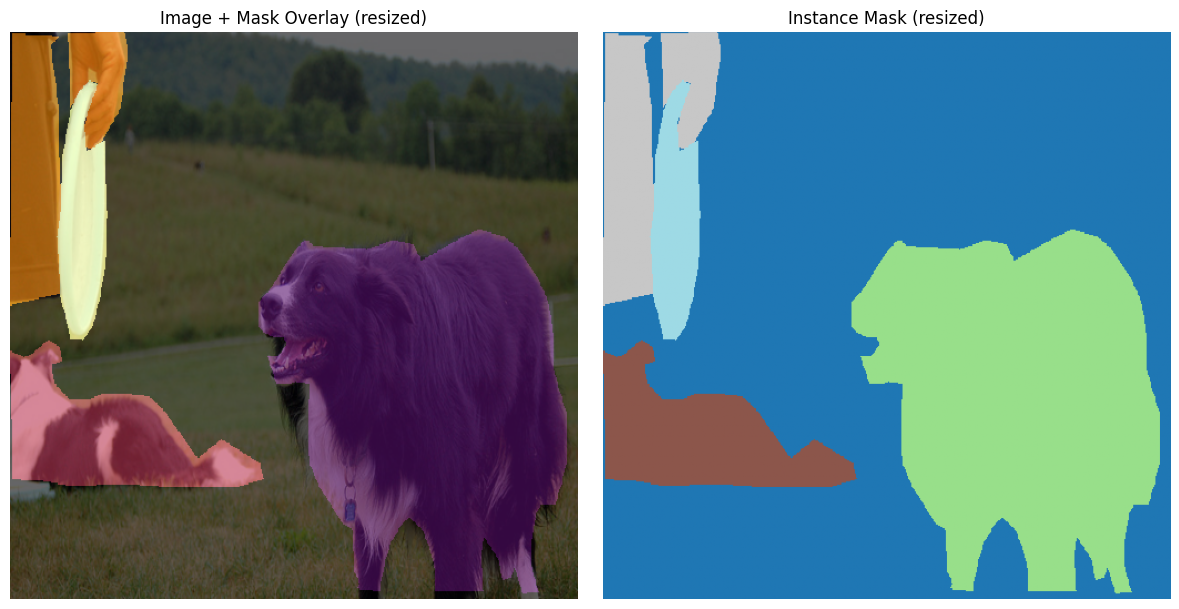

In [24]:
import matplotlib.pyplot as plt

# Fetch a sample (now tensors):
image, mask = dataset[2]

# image: torch.Tensor (C,H,W) in [0,1], mask: torch.LongTensor (H,W)
image_np = image.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.imshow(mask_np, cmap="inferno", alpha=0.6)
plt.title("Image + Mask Overlay (resized)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="tab20")
plt.title("Instance Mask (resized)")
plt.axis("off")

plt.tight_layout()
plt.show()